# MODULE IMPORTS

In [1]:
## IMPORTS ##

import pandas as pd # data processing, CSV file I/O
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import seaborn as sns
import datetime

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import pickle

from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# DATA IMPORT

In [2]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
data_loc = './data'

store_sales = pd.read_csv(f'{data_loc}/train.csv', dtype=dtype, parse_dates=['date'], infer_datetime_format=True)
test = pd.read_csv(f'{data_loc}/test.csv', dtype=dtype, parse_dates=['date'])
oil = pd.read_csv(f'{data_loc}/oil.csv', parse_dates=['date'])
transactions = pd.read_csv(f'{data_loc}/transactions.csv', parse_dates=['date'])
holidays_events = pd.read_csv(f'{data_loc}/holidays_events.csv', parse_dates=['date'])
stores = pd.read_csv(f'{data_loc}/stores.csv')

sample_submission = pd.read_csv(f'{data_loc}/sample_submission.csv')

In [15]:
holidays_events = pd.read_csv(
    f'{data_loc}/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',},
    parse_dates=['date'],
    infer_datetime_format=True,)

test = pd.read_csv(
    f'{data_loc}/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales = pd.read_csv(
    f'{data_loc}/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,)

# EXPLORATORY DATA ANALYSIS

In [3]:
## DATA CLEANING

def data_info(data):
    display(data.head())
    print()

    display(data.tail())
    print()

    display(data.shape)
    print()

    display(data.info())
    print()

    try:
        display(data.select_dtypes(include=['object']).describe())
        print()
    except:
        print('No object data')
        print()
    finally:
        display(data.describe())
        print()
    
    display(data.isna().sum())
    print()

    total_missing_values = data.isna().sum().sum()
    total_cells = np.product(data.shape)

    print(f'Total missing values: {total_missing_values}')
    print(f'Total cells: {total_cells}')
    print(f'Percentage of missing values: {total_missing_values / total_cells * 100}')

In [4]:
def data_imputation(X, y=None, strategy='mean'):
    imputer = SimpleImputer(missing_values=np.nan ,strategy=strategy)
    X = imputer.fit(X)
    if y is not None:
        y = imputer.fit(y)
    return X, y

In [5]:
print('STORE SALES')
data_info(store_sales)

STORE SALES


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000000,0


(3000888, 6)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    category      
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(2), datetime64[ns](1), float32(1), int64(1), uint64(1)
memory usage: 85.9 MB


None


No object data



,id,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,3.577758e+02,2.602770e+00
std,8.662819e+05,1.101998e+03,1.221888e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,0.000000e+00,0.000000e+00
50%,1.500444e+06,1.100000e+01,0.000000e+00
75%,2.250665e+06,1.958473e+02,0.000000e+00
max,3.000887e+06,1.247170e+05,7.410000e+02


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


Total missing values: 0
Total cells: 18005328
Percentage of missing values: 0.0


In [6]:
print('Training data')
data_info(test)

Training data


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
28511,3029399,2017-08-31,9,SEAFOOD,0


(28512, 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  category      
 3   family       28512 non-null  category      
 4   onpromotion  28512 non-null  uint64        
dtypes: category(2), datetime64[ns](1), int64(1), uint64(1)
memory usage: 724.7 KB


None


No object data



,id,onpromotion
count,2.851200e+04,28512.000000
mean,3.015144e+06,6.965383
std,8.230850e+03,20.683952
min,3.000888e+06,0.000000
25%,3.008016e+06,0.000000
50%,3.015144e+06,0.000000
75%,3.022271e+06,6.000000
max,3.029399e+06,646.000000


id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


Total missing values: 0
Total cells: 142560
Percentage of missing values: 0.0


In [7]:
print('Stores')
data_info(stores)

Stores


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


(54, 5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


None

,city,state,type
count,54,54,54
unique,22,16,5
top,Quito,Pichincha,D
freq,18,19,18


,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


Total missing values: 0
Total cells: 270
Percentage of missing values: 0.0


In [8]:
print('Oil')
data_info(oil)

Oil


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


(1218, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


None


No object data



,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


date           0
dcoilwtico    43
dtype: int64


Total missing values: 43
Total cells: 2436
Percentage of missing values: 1.7651888341543513


In [9]:
print('Transactions')
data_info(transactions)

Transactions


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


(83488, 3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


None


No object data



,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


date            0
store_nbr       0
transactions    0
dtype: int64


Total missing values: 0
Total cells: 250464
Percentage of missing values: 0.0


In [10]:
print('Holidays and events')
data_info(holidays_events)

Holidays and events


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


(350, 6)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


None

,type,locale,locale_name,description
count,350,350,350,350
unique,6,3,24,103
top,Holiday,National,Ecuador,Carnaval
freq,221,174,174,10


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25 00:00:00,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
first,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


Total missing values: 0
Total cells: 2100
Percentage of missing values: 0.0


In [11]:
## Plot styling
plt.style.use('seaborn-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(16, 10),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight='bold',
    labelsize="large",
    titlesize=16,
    titleweight='bold',
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

## DATA CLEANING

### Universal variables

In [26]:
full_train_start_day = datetime.datetime(2015, 6, 16)
full_train_end_day = datetime.datetime(2017, 8, 15)

train_start_day = full_train_start_day
train_end_day = datetime.datetime(2017, 7, 30)
val_start_day = datetime.datetime(2017, 7, 31)
val_end_day = datetime.datetime(2017, 8, 15)

test_start_day = datetime.datetime(2017, 8, 16)
test_end_day = datetime.datetime(2017, 8, 31)

In [31]:
max_lag = 7

model_1 = LinearRegression()
model_2 = XGBRegressor()

model_3 = KNeighborsRegressor()
model_4 = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)

hybrid_forecasting_type = "day_by_day_refit_all_days"

In [14]:
## ADDING NEW FEATURE ##
total_daily_sales = (
    store_sales.drop(columns = 'onpromotion')
    .groupby(['date', 'store_nbr'])
    .sum()
    .reset_index()
)

## Avg sales per day ##
stores_temp = pd.merge(transactions, total_daily_sales, on=['date', 'store_nbr']).drop(columns = 'id')
stores_temp['avg_ticket'] = stores_temp['sales'] / stores_temp['transactions']

## Old stores ##
old_stores = stores_temp[stores_temp['date'] == '2013-01-02'].store_nbr.values
stores['old'] = stores['store_nbr'].isin(old_stores)

## Start date for store ##
stores['start_date'] = [stores_temp[stores_temp['store_nbr'] == num]['date'].dt.date.min() for num in range(1,55)]
stores['start_date'] = pd.to_datetime(stores['start_date'])

## Wage expense ##
stores_temp['wage'] = (stores_temp['date'].dt.is_month_end) | (stores_temp['date'].dt.day == 15)

daily_store_totals = pd.merge(stores_temp, stores, on='store_nbr')

In [16]:
holidays_events['date'] = holidays_events['date'].replace({'2013-04-29': pd.to_datetime('2013-03-29')}) #Correction in data
holidays_events = holidays_events.set_index('date').to_period('D').sort_index()

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [17]:
store_sales['date'] = store_sales.date.dt.to_period('D')

m_index = pd.MultiIndex.from_product([store_sales["store_nbr"].unique(), store_sales["family"].unique(), pd.date_range(start="2013-1-1", end="2017-8-15", freq="D").to_period('D')], names=["store_nbr", "family", "date"])

store_sales = store_sales.set_index(["store_nbr", "family", "date"]).reindex(m_index, fill_value=0).sort_index()
store_sales = store_sales.unstack(['store_nbr', 'family']).fillna(0)

store_sales = store_sales.stack(['store_nbr', 'family'])
store_sales = store_sales[['sales', 'onpromotion']]

## CALENDAR FOR HOLIDAYS INCLUDED

In [18]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
calendar['dofw'] = calendar.index.dayofweek

df_hev = holidays_events[holidays_events.locale == 'National']
df_hev = df_hev.groupby(df_hev.index).first()

calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_hev, how='left', left_index=True, right_index=True)

calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

In [19]:
calendar.head(15)

,dofw,wd,type,locale,locale_name,description,transferred
2013-01-01,1,False,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-02,2,True,NaN,NaN,NaN,NaN,NaN
2013-01-03,3,True,NaN,NaN,NaN,NaN,NaN
2013-01-04,4,True,NaN,NaN,NaN,NaN,NaN
2013-01-05,5,True,Work Day,National,Ecuador,Recupero puente Navidad,False
2013-01-06,6,False,NaN,NaN,NaN,NaN,NaN
2013-01-07,0,True,NaN,NaN,NaN,NaN,NaN
2013-01-08,1,True,NaN,NaN,NaN,NaN,NaN
2013-01-09,2,True,NaN,NaN,NaN,NaN,NaN
2013-01-10,3,True,NaN,NaN,NaN,NaN,NaN


In [20]:
calendar.tail(15)

,dofw,wd,type,locale,locale_name,description,transferred
2017-08-17,3,True,NaN,NaN,NaN,NaN,NaN
2017-08-18,4,True,NaN,NaN,NaN,NaN,NaN
2017-08-19,5,False,NaN,NaN,NaN,NaN,NaN
2017-08-20,6,False,NaN,NaN,NaN,NaN,NaN
2017-08-21,0,True,NaN,NaN,NaN,NaN,NaN
2017-08-22,1,True,NaN,NaN,NaN,NaN,NaN
2017-08-23,2,True,NaN,NaN,NaN,NaN,NaN
2017-08-24,3,True,NaN,NaN,NaN,NaN,NaN
2017-08-25,4,True,NaN,NaN,NaN,NaN,NaN
2017-08-26,5,False,NaN,NaN,NaN,NaN,NaN


In [27]:
holidays_events.loc[full_train_start_day:test_end_day]

,type,locale,locale_name,description,transferred
date,,,,,
2015-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
2015-06-25,Holiday,Local,Machala,Fundacion de Machala,False
2015-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
2015-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
2015-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
...,...,...,...,...,...
2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


# MODEL

## BOOSTED HYBRID MODEL

In [ ]:
class BoostedHybridModel:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None
        self.y_resid = None

    def fit1(self, X_1, y, stack_cols=None):
        self.model_1.fit(X_1, y) 
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index,
            columns=y.columns,
        )
        self.y_resid = y - y_fit 
        self.y_resid = self.y_resid.stack(stack_cols).squeeze()  
        
    def fit2(self, X_2, first_n_rows_to_ignore, stack_cols=None):
        self.model_2.fit(X_2.iloc[first_n_rows_to_ignore*1782: , :], self.y_resid.iloc[first_n_rows_to_ignore*1782:]) 
        self.y_columns = y.columns 
        self.stack_cols = stack_cols 

    def predict(self, X_1, X_2, first_n_rows_to_ignore):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1.iloc[first_n_rows_to_ignore: , :]),
            index=X_1.iloc[first_n_rows_to_ignore: , :].index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  
        y_pred += self.model_2.predict(X_2.iloc[first_n_rows_to_ignore*1782: , :]) 
        return y_pred.unstack(self.stack_cols)

## FEATURE GENERATION

In [40]:
def make_det_proc_features(df):
    y = df.loc[:, 'sales']
    fourier_m = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier_m],
        drop=True,
    )
    return y, dp

def make_X1_features(df, start_date, end_date, is_test_set=False):
    if is_test_set:
        X1 = df.rename_axis('date')
    else:
        y, dp = make_det_proc_features(df)
        X1 = dp.in_sample() 
    
    X1['NewYear'] = (X1.index.dayofyear == 1)
    X1['Christmas'] = (X1.index=='2016-12-25') | (X1.index=='2015-12-25') | (X1.index=='2014-12-25') | (X1.index=='2013-12-25')
    X1['wd']   = calendar.loc[start_date:end_date]['wd'].values
    X1['type'] = calendar.loc[start_date:end_date]['type'].values
    X1 = pd.get_dummies(X1, columns=['type'], drop_first=False)
    
    if is_test_set:
        return X1
    else:
        return X1, y, dp

In [30]:
def encode_categoricals(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

def make_X2_lags(ts, lags, lead_time=1, name='y', stack_cols=None):
    ts = ts.unstack(stack_cols)
    df = pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i, freq="D") for i in range(lead_time, lags + lead_time)
        },
        axis=1
    )

    df = df.stack(stack_cols).reset_index()
    df = encode_categoricals(df, stack_cols)
    df = df.set_index('date').sort_values(by=stack_cols)

    return df

def make_X2_features(df, y_resid):
    stack_columns = ['store_nbr', 'family']

    shifted_promo_df = make_X2_lags(df.squeeze(), lags=2, lead_time=1, name='promo', stack_cols=stack_columns)
    shifted_promo_df['promo_mean_rolling_7'] = shifted_promo_df['promo_lag_1'].rolling(window=7, center=False).mean()
    shifted_promo_df['promo_median_rolling_91'] = shifted_promo_df['promo_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
    shifted_promo_df['promo_median_rolling_162'] = shifted_promo_df['promo_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')

    shifted_y_df = make_X2_lags(y_resid, lags=2, lead_time=1, name='y_res', stack_cols=stack_columns)
    shifted_y_df['y_mean_rolling_7'] = shifted_y_df['y_res_lag_1'].rolling(window=7, center=False).mean()
    shifted_y_df['y_median_rolling_91'] = shifted_y_df['y_res_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
    shifted_y_df['y_median_rolling_162'] = shifted_y_df['y_res_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')

    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)

    X2["day_of_w"] = X2.index.dayofweek 
    X2 = encode_categoricals(df, ['day_of_w'])
    old_stores_strings = list(map(str, old_stores))
    X2['old'] = X2['store_nbr'].isin(old_stores_strings) 
    X2['wage_day'] = (X2.index.day == X2.index.daysinmonth) | (X2.index.day == 15)
    X2['wage_day_lag_1'] = (X2.index.day == 1) | (X2.index.day == 16)
    X2['promo_mean'] = X2.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001
    X2['promo_ratio'] = X2.onpromotion / (X2.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001)

    X2 = X2.merge(shifted_y_df, on=['date', 'store_nbr', 'family'], how='left')
    X2 = X2.merge(shifted_promo_df, on=['date', 'store_nbr', 'family'], how='left')

    return X2  

# TESTING FEATURE SET

In [43]:
%%time
store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc[full_train_start_day:full_train_end_day]

model = BoostedHybridModel(model_1=model_1, model_2=model_2)

X_1, y, dp = make_X1_features(store_sales_in_date_range, full_train_start_day, full_train_end_day)
model.fit1(X_1, y, stack_cols=['store_nbr', 'family'])

X_2 = make_X2_features(store_sales_in_date_range.drop('sales', axis=1).stack(['store_nbr', 'family']), model.y_resid)
model.fit2(X_2, max_lag, stack_cols=['store_nbr', 'family'])

y_pred = model.predict(X_1, X_2,max_lag).clip(0,0)

CPU times: user 13min 49s, sys: 11.1 s, total: 14min
Wall time: 2min 8s


In [47]:
def truncateFloat(data):
    return tuple(["{0:.2f}".format(x) if isinstance(x, float) else (x if not isinstance(x, tuple) else truncateFloat(x)) for x in data])

temp = X_2[(X_2.store_nbr == 1) & (X_2.family == 3)]
temp.iloc[max_lag: , :].apply(lambda s : truncateFloat(s))

# temp.apply(lambda s : truncateFloat(s)).head()

,store_nbr,family,onpromotion,day_of_w,old,wage_day,wage_day_lag_1,promo_mean,promo_ratio,y_res_lag_1,y_res_lag_2,y_mean_rolling_7,y_median_rolling_91,y_median_rolling_162,promo_lag_1,promo_lag_2,promo_mean_rolling_7,promo_median_rolling_91,promo_median_rolling_162
date,,,,,,,,,,,,,,,,,,,
2015-06-23,1,3,1,1,False,False,False,13.70,0.07,95.98,-274.02,41.76,21.22,9.63,1.00,1.00,4.57,1.00,2.00
2015-06-24,1,3,30,2,False,False,False,13.70,2.19,-5.00,95.98,25.66,21.22,9.63,1.00,1.00,4.57,1.00,2.00
2015-06-25,1,3,0,3,False,False,False,13.70,0.00,-66.04,-5.00,8.22,21.22,9.63,30.00,1.00,5.14,1.00,2.00
2015-06-26,1,3,0,4,False,False,False,13.70,0.00,119.51,-66.04,12.80,21.22,9.63,0.00,30.00,5.00,1.00,2.00
2015-06-27,1,3,0,5,False,False,False,13.70,0.00,-3.05,119.51,-5.22,21.22,9.63,0.00,0.00,4.71,1.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1,3,23,4,False,False,False,13.70,1.68,753.29,148.94,273.91,12.20,28.53,23.00,26.00,24.29,21.00,21.00
2017-08-12,1,3,23,5,False,False,False,13.70,1.68,293.66,753.29,255.86,18.77,28.53,23.00,23.00,24.00,22.00,21.00
2017-08-13,1,3,25,6,False,False,False,13.70,1.82,-128.24,293.66,217.63,18.77,22.76,23.00,23.00,23.57,22.00,21.00


In [45]:
X_1.iloc[max_lag: , :].apply(lambda s : truncateFloat(s))

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"cos(4,freq=M)",NewYear,Christmas,wd,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,,,,,,
2015-06-23,1.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.99,-0.10,...,0.91,False,False,True,0,0,0,0,0,0
2015-06-24,1.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.99,0.10,...,0.91,False,False,True,0,0,0,0,0,0
2015-06-25,1.00,10.00,0.00,1.00,0.00,0.00,0.00,0.00,-0.95,0.31,...,0.31,False,False,True,0,0,0,0,0,0
2015-06-26,1.00,11.00,0.00,0.00,1.00,0.00,0.00,0.00,-0.87,0.50,...,-0.50,False,False,True,0,0,0,0,0,0
2015-06-27,1.00,12.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.74,0.67,...,-0.98,False,False,False,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.00,788.00,0.00,0.00,1.00,0.00,0.00,0.00,0.90,-0.44,...,-0.25,False,False,False,0,0,0,0,1,0
2017-08-12,1.00,789.00,0.00,0.00,0.00,1.00,0.00,0.00,0.79,-0.61,...,-0.87,False,False,False,0,0,0,0,0,0
2017-08-13,1.00,790.00,0.00,0.00,0.00,0.00,1.00,0.00,0.65,-0.76,...,-0.95,False,False,False,0,0,0,0,0,0


In [49]:
display(store_sales.index.get_level_values('family').unique())

Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')

Text(0.5, 1.0, 'BEVERAGES Sales at Store 10')

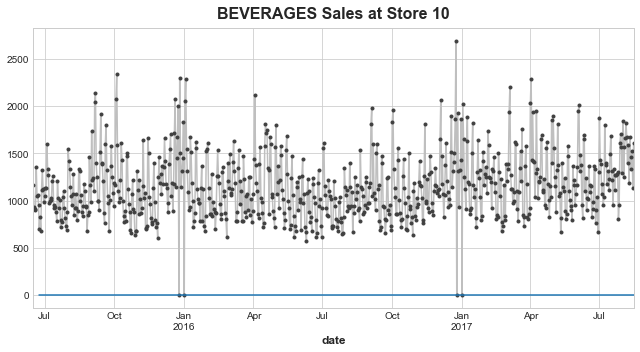

In [56]:
STORE_NBR = '10'
FAMILY = 'BEVERAGES'

ax = y.loc(axis=1)[STORE_NBR, FAMILY].plot(**plot_params, figsize=(9,5))
ax = y_pred.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

# VALIDATION

In [57]:
training_days = (train_end_day - train_start_day).days + 1
validation_days = (val_end_day - val_start_day).days + 1

print(f'Training days: {training_days} days')
print(f'Validation days: {validation_days} days')

store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc[train_start_day:train_end_day]
store_data_in_val_range = store_sales.unstack(['store_nbr', 'family']).loc[val_start_day:val_end_day]

y_val = y[val_start_day:val_end_day]

model_for_val = BoostedHybridModel(model_1=model_1, model_2=model_2)

Training days: 776 days
Validation days: 16 days


In [58]:
if hybrid_forecasting_type == "direct":
    X_1_train, y_train, dp_val = make_X1_features(store_sales_in_date_range, train_start_day, train_end_day)
    model_for_val.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family'])

    X_2_train = make_X2_features(store_sales_in_date_range.drop('sales', axis=1).stack(['store_nbr', 'family']), model_for_val.y_resid)
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

    X_1_val = make_X1_features(dp_val.out_of_sample(steps=validation_days), val_start_day, val_end_day, is_test_set=True)
    X_2_val = make_X2_features(store_data_in_val_range.drop('sales', axis=1).stack(['store_nbr', 'family']), model_for_val.y_resid)

    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0,0)
    y_pred = model_for_val.predict(X_1_val, X_2_val, 0).clip(0,0)

    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))

        print("XGBRegressor parameters:\n", m2.get_xgb_params(), "\n")

In [59]:
if hybrid_forecasting_type == "day_by_day_fixed_past":
    X_1_train, y_train, dp_val = make_X1_features(store_sales_in_date_range, train_start_day, train_end_day) 
    model_for_val.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) 
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_val.y_resid) 
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])
    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0.0)

    y_pred_combined = y_fit.copy() 
    dp_for_full_X1_val_date_range = dp_val.out_of_sample(steps=validation_days)
    for step in range(validation_days):
        dp_steps_so_far = dp_for_full_X1_val_date_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_val.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_data_in_val_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step), :]])
        X_1_val = make_X1_features(X_1_combined_dp_data, train_start_day, val_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_val = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_val.y_resid) 

        y_pred_combined = pd.concat([y_pred_combined,
                                     model_for_val.predict(X_1_val, X_2_val, max_lag).clip(0.0).iloc[-1:]
                                    ])
    
        y_plus_y_val = pd.concat([y_train, y_pred_combined.iloc[-(step+1):]]) 
        model_for_val.fit1(X_1_val, y_plus_y_val, stack_cols=['store_nbr', 'family']) 
        model_for_val.fit2(X_2_val, max_lag, stack_cols=['store_nbr', 'family'])

        rmsle_valid = mean_squared_log_error(y_val.iloc[step:step+1], y_pred_combined.iloc[-1:]) ** 0.5
        print(f'Validation RMSLE: {rmsle_valid:.5f}', "for", val_start_day+pd.Timedelta(days=step))

    y_pred = y_pred_combined[val_start_day:val_end_day]
    print("\ny_pred: ")
    display(y_pred.apply(lambda s: truncateFloat(s)))
    
    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

In [60]:
%%time

if hybrid_forecasting_type == "day_by_day_refit_all_days":
    X_1_train, y_train, dp_val = make_X1_features(store_sales_in_date_range, train_start_day, train_end_day)
    model_for_val.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family'])

    X_2_train = make_X2_features(store_sales_in_date_range.drop('sales', axis=1).stack(['store_nbr', 'family']), model_for_val.y_resid)
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0,0)
    dp_for_full_X1_val_date_range = dp_val.out_of_sample(steps=validation_days)

    for step in range(validation_days):
        dp_steps_so_far = dp_for_full_X1_val_date_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_val.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_data_in_val_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step), :]])
        
        X_1_val = make_X1_features(X_1_combined_dp_data, train_start_day, val_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_val = make_X2_features(X_2_combined_data.drop('sales', axis=1).stack(['store_nbr', 'family']), model_for_val.y_resid)

        y_pred_combined = model_for_val.predict(X_1_val, X_2_val, max_lag).clip(0.0)

        y_plus_y_val = pd.concat([y_train, y_pred_combined.iloc[-(step+1):]])
        model_for_val.fit1(X_1_val, y_plus_y_val, stack_cols=['store_nbr', 'family'])
        model_for_val.fit2(X_2_val, max_lag, stack_cols=['store_nbr', 'family'])

        rmsle_valid = mean_squared_log_error(y_val.iloc[step:step+1], y_pred_combined.iloc[-1:]) ** 0.5
        print(f'Validation RMSLE: {rmsle_valid:.5f}', "for", val_start_day+pd.Timedelta(days=step))

    y_pred = y_pred_combined[val_start_day:val_end_day]
    print("\ny_pred: ")
    display(y_pred.apply(lambda s: truncateFloat(s)))


    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))

        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

Validation RMSLE: 0.48520 for 2017-07-31 00:00:00
Validation RMSLE: 0.70736 for 2017-08-01 00:00:00
Validation RMSLE: 0.48724 for 2017-08-02 00:00:00
Validation RMSLE: 0.49333 for 2017-08-03 00:00:00
Validation RMSLE: 0.47998 for 2017-08-04 00:00:00
Validation RMSLE: 0.45794 for 2017-08-05 00:00:00
Validation RMSLE: 0.48211 for 2017-08-06 00:00:00
Validation RMSLE: 0.48062 for 2017-08-07 00:00:00
Validation RMSLE: 0.49457 for 2017-08-08 00:00:00
Validation RMSLE: 0.47173 for 2017-08-09 00:00:00
Validation RMSLE: 0.55068 for 2017-08-10 00:00:00
Validation RMSLE: 0.52892 for 2017-08-11 00:00:00
Validation RMSLE: 0.52989 for 2017-08-12 00:00:00
Validation RMSLE: 0.52701 for 2017-08-13 00:00:00
Validation RMSLE: 0.51357 for 2017-08-14 00:00:00
Validation RMSLE: 0.50820 for 2017-08-15 00:00:00

y_pred: 


store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-07-31       3.99      0.00   3.40   2417.11  0.37       399.24   
2017-08-01       7.53      2.49   6.73   2493.09  3.20       384.63   
2017-08-02       4.83      0.00   7.32   2665.15  0.47       451.34   
2017-08-03       4.27      0.00   6.93   2232.12  0.29       394.41   
2017-08-04       5.28      0.00   6.82   2552.71  0.38       436.97   
2017-08-05       5.18      0.00   6.86   2442.75  0.28       407.71   
2017-08-06       1.94      0.00   5.15   1085.60  0.18       150.26   
2017-08-07       4.13      0.00   6.72   2257.98  0.35       420.28   
2017-08-08       4.57      0.00   6.73   2168.59  0.45       386.47   
2017-08-09       4.67      0.00   6.98   2413.23  0.51       457.90   
2017-08-10       4.31      0.00   5.59   1761.56  0.16       337.41   
2017-08-11       2.30      0.00   4.92   1203.75  0.14       192.46   
2017-08-12       5.10      0.00   6.67   2358.52  0.51       409.35   
2017-08-13       2.07      0.00   1.91   1057.08  0.43       156.96   
2017-08-14       4.43      0.00   6.52   2255.03  0.56       425.92   
2017-08-15       4.95      0.00   6.53   2203.49  0.60       394.90   

store_nbr                                        ...         9          \
family     CELEBRATION CLEANING   DAIRY    DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2017-07-31       13.65   720.21  722.89  158.73  ...      2.56  425.54   
2017-08-01       18.60   823.68  680.77  172.31  ...      5.90  454.97   
2017-08-02       18.40   931.55  828.06  157.08  ...      2.93  455.65   
2017-08-03       18.50   749.77  703.36  129.66  ...      3.11  618.18   
2017-08-04       23.42   839.48  854.28  178.04  ...      2.66  374.25   
2017-08-05       13.66   669.07  831.11  137.05  ...      4.08  475.05   
2017-08-06        3.83   268.12  344.33   48.17  ...      5.08  492.04   
2017-08-07       14.10   674.70  770.90  143.20  ...      2.18  395.24   
2017-08-08       16.29   685.16  764.69  134.41  ...      2.74  367.25   
2017-08-09       18.89   789.09  921.70  143.91  ...      2.93  344.88   
2017-08-10       18.51   567.20  671.40  104.76  ...      2.85  482.83   
2017-08-11        7.88   273.09  395.20   66.77  ...      4.70  381.17   
2017-08-12       14.77   579.49  824.36  133.31  ...      5.47  395.01   
2017-08-13        4.43   178.31  385.69   50.55  ...      6.17  435.12   
2017-08-14       14.43   639.17  804.96  141.01  ...      3.23  355.78   
2017-08-15       16.27   665.11  775.50  134.02  ...      3.65  350.87   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-07-31        551.16         7.87                    8.49  441.54   
2017-08-01        662.66        11.00                   18.10  480.92   
2017-08-02        625.04         9.12                   10.27  466.62   
2017-08-03        607.69         8.37                   11.43  466.92   
2017-08-04        522.32         7.82                    9.15  528.36   
2017-08-05        745.38        10.11                   14.87  596.94   
2017-08-06        760.56        10.92                   16.38  658.03   
2017-08-07        512.09         6.72                    9.11  411.06   
2017-08-08        471.69         6.22                    8.07  372.74   
2017-08-09        394.82         6.67                    6.70  326.22   
2017-08-10        338.21         5.95                    8.93  322.60   
2017-08-11        567.15         8.54                   15.30  568.16   
2017-08-12        532.91         9.19                   12.61  527.61   
2017-08-13        604.19        10.67                   14.81  626.77   
20

XGBRegressor paramaters:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 

CPU times: user 3h 49min 46s, sys: 2min 45s, total: 3h 52min 32s
Wall time: 35min 17s


In [63]:
rmsle_train = mean_squared_log_error(y_train.iloc[max_lag: , :].clip(0.0), y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_val.clip(0.0), y_pred) ** 0.5

print(f'Train RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_predict = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y_val.stack(['store_nbr', 'family']).reset_index().copy()

y_target.rename(columns={y_target.columns[3]:'sales'}, inplace=True)
y_target['sales_pred'] = y_predict[0].clip(0.0) 
y_target['store_nbr'] = y_target['store_nbr'].astype(int)

print('\nValidation RMSLE by family')
display(y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))

print('\nValidation RMSLE by store')
display(y_target.sort_values(by="store_nbr").groupby('store_nbr').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))

Train RMSLE: 4.31030
Validation RMSLE: 0.51224

Validation RMSLE by family


family
AUTOMOTIVE                    0.296856
BABY CARE                     0.188928
BEAUTY                        0.408391
BEVERAGES                     0.056404
BOOKS                         0.190162
BREAD/BAKERY                  0.043554
CELEBRATION                   0.336101
CLEANING                      0.102400
DAIRY                         0.035477
DELI                          0.039942
EGGS                          0.114897
FROZEN FOODS                  0.219747
GROCERY I                     0.032277
GROCERY II                    0.349531
HARDWARE                      0.340552
HOME AND KITCHEN I            0.301910
HOME AND KITCHEN II           0.325004
HOME APPLIANCES               0.252056
HOME CARE                     0.059614
LADIESWEAR                    0.403799
LAWN AND GARDEN               0.295210
LINGERIE                      0.508974
LIQUOR,WINE,BEER              0.380292
MAGAZINES                     0.303633
MEATS                         0.191081
PERSONAL CARE     


Validation RMSLE by store


store_nbr
1     0.174186
2     0.175043
3     0.180646
4     0.153491
5     0.195247
6     0.135119
7     0.135373
8     0.157034
9     0.298785
10    0.218830
11    0.217983
12    0.219247
13    0.212392
14    0.265453
15    0.244428
16    0.341704
17    0.227662
18    0.281391
19    0.296400
20    0.306410
21    0.302617
22    0.328769
23    0.238889
24    0.201455
25    0.338552
26    0.363217
27    0.168790
28    0.251192
29    0.198307
30    0.265653
31    0.259446
32    0.396813
33    0.299253
34    0.319554
35    0.279276
36    0.425885
37    0.160652
38    0.224336
39    0.451756
40    0.290494
41    0.189135
42    0.257798
43    0.275189
44    0.409261
45    0.161048
46    0.121372
47    0.490694
48    0.356577
49    0.174315
50    0.511857
51    0.242283
52    0.212390
53    0.300195
54    0.264942
dtype: float64

# TEST SET DATA

In [73]:
train_days = (full_train_end_day - full_train_start_day).days + 1
test_days = (test_end_day - test_start_day).days + 1

print(f'Train days: {train_days} days')
print("test forecasting period is", test_days, "days through", test_end_day, "\n")

store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc[full_train_start_day:full_train_end_day]
store_sales_in_test_range = test.unstack(['store_nbr', 'family']).drop('id', axis=1)

model_for_test = BoostedHybridModel(model_1=model_1, model_2=model_2)

Train days: 792 days
test forecasting period is 16 days through 2017-08-31 00:00:00 



In [74]:
if hybrid_forecasting_type == "direct":
    X_1_test = make_X1_features(dp.out_of_sample(steps=int(test_days)), test_start_day, test_end_day, is_test_set=True)
    X_2_test = make_X2_features(store_sales_in_test_range.loc[test_start_day:test_end_day]
                                .stack(['store_nbr', 'family']),
                                model.y_resid) # preparing X2 for hybrid part 2: XGBoost
    y_forecast = pd.DataFrame(model.predict(X_1_test, X_2_test, 0).clip(0.0), index=X_1_test.index, columns=y.columns) # set max_lag to 0 because need entire time span for test data set
    
    if type(model.model_2) == XGBRegressor:
        pickle.dump(model.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

In [76]:
if hybrid_forecasting_type == "day_by_day_fixed_past":
    
    X_1_train, y_train, dp_test = make_X1_features(store_sales_in_date_range, full_train_start_day, full_train_end_day) 
    model_for_test.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) 
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_test.y_resid) 
    model_for_test.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

    y_forecast_combined = model_for_test.predict(X_1_train, X_2_train, max_lag).clip(0.0) 

    dp_for_full_X1_test_date_range = dp_test.out_of_sample(steps=test_days)
    for step in range(test_days):
        dp_steps_so_far = dp_for_full_X1_test_date_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_test.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_sales_in_test_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step), :]])
        X_1_test = make_X1_features(X_1_combined_dp_data, train_start_day, test_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_test = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_test.y_resid) 

        y_forecast_combined = pd.concat([y_forecast_combined,
                                     model_for_test.predict(X_1_test, X_2_test, max_lag).clip(0.0).iloc[-1:]
                                    ])   
    

        y_plus_y_test = pd.concat([y_train, y_forecast_combined.iloc[-(step+1):]]) 
        model_for_test.fit1(X_1_test, y_plus_y_test, stack_cols=['store_nbr', 'family']) 
        model_for_test.fit2(X_2_test, max_lag, stack_cols=['store_nbr', 'family'])
        print("finished forecast for", test_start_day+pd.Timedelta(days=step))

    display(y_forecast_combined[test_start_day:test_end_day])
    y_forecast = pd.DataFrame(y_forecast_combined[test_start_day:test_end_day].clip(0.0), index=X_1_test.index, columns=y.columns)
    print('\nFinished creating test set forecast\n')
    
    if type(model_for_test.model_2) == XGBRegressor:
        pickle.dump(model_for_test.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

In [77]:
%%time

if hybrid_forecasting_type == "day_by_day_refit_all_days":
    
    X_1_train, y_train, dp_test = make_X1_features(store_sales_in_date_range, full_train_start_day, full_train_end_day) 
    model_for_test.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family']) 
    X_2_train = make_X2_features(store_sales_in_date_range
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_test.y_resid) 
    model_for_test.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])
    


    dp_for_full_X1_test_date_range = dp_test.out_of_sample(steps=test_days)
    for step in range(test_days):
        dp_steps_so_far = dp_for_full_X1_test_date_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step),:]

        X_1_combined_dp_data = pd.concat([dp_test.in_sample(), dp_steps_so_far])
        X_2_combined_data = pd.concat([store_sales_in_date_range,
                                       store_sales_in_test_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step), :]])
        X_1_test = make_X1_features(X_1_combined_dp_data, train_start_day, test_start_day+pd.Timedelta(days=step), is_test_set=True)
        X_2_test = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_test.y_resid) 

        y_forecast_combined = model_for_test.predict(X_1_test, X_2_test, max_lag).clip(0.0) 

        y_plus_y_test = pd.concat([y_train, y_forecast_combined.iloc[-(step+1):]]) 
        model_for_test.fit1(X_1_test, y_plus_y_test, stack_cols=['store_nbr', 'family']) 
        model_for_test.fit2(X_2_test, max_lag, stack_cols=['store_nbr', 'family'])
        print("finished forecast for", test_start_day+pd.Timedelta(days=step))

    display(y_forecast_combined[test_start_day:test_end_day])

    y_forecast = pd.DataFrame(y_forecast_combined[test_start_day:test_end_day].clip(0.0), index=X_1_test.index, columns=y.columns)
    print('\nFinished creating test set forecast\n')
    
    if type(model_for_test.model_2) == XGBRegressor:
        pickle.dump(model_for_test.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

finished forecast for 2017-08-16 00:00:00
finished forecast for 2017-08-17 00:00:00
finished forecast for 2017-08-18 00:00:00
finished forecast for 2017-08-19 00:00:00
finished forecast for 2017-08-20 00:00:00
finished forecast for 2017-08-21 00:00:00
finished forecast for 2017-08-22 00:00:00
finished forecast for 2017-08-23 00:00:00
finished forecast for 2017-08-24 00:00:00
finished forecast for 2017-08-25 00:00:00
finished forecast for 2017-08-26 00:00:00
finished forecast for 2017-08-27 00:00:00
finished forecast for 2017-08-28 00:00:00
finished forecast for 2017-08-29 00:00:00
finished forecast for 2017-08-30 00:00:00
finished forecast for 2017-08-31 00:00:00


store_nbr           1                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-08-16   3.968019  0.043969  22.059293  2498.933437  0.148540   
2017-08-17   3.453178  0.033101   7.443623  2168.548589  0.190786   
2017-08-18   4.401822  0.030045   7.433740  2467.672661  0.268409   
2017-08-19   4.370233  0.025562   7.513013  2435.096616  0.161087   
2017-08-20   1.989261  0.659450   8.112814  1134.542025  0.712543   
2017-08-21   3.833016  0.025439   9.019906  2375.445063  0.235650   
2017-08-22   4.438721  0.022773   5.056067  2210.861456  0.287199   
2017-08-23   4.370778  0.033257   9.365624  2440.930735  0.324487   
2017-08-24   3.706853  0.024036   5.305531  2068.746779  0.144934   
2017-08-25   4.653203  0.024107   5.370359  2335.724416  0.209365   
2017-08-26   4.525141  0.022944   7.724887  2280.388726  0.065925   
2017-08-27   1.984771  0.659361   6.617080   894.321088  0.575802   
2017-08-28   3.664958  0.026650   7.891079  2201.967665  0.074033   
2017-08-29   4.170629  0.024108   7.754978  2178.296065  0.134072   
2017-08-30   4.119375  0.033859   5.870406  2467.086064  0.216388   
2017-08-31   3.606963  0.023430   8.019476  2176.501272  0.106169   

store_nbr                                                                ...  \
family     BREAD/BAKERY CELEBRATION    CLEANING       DAIRY        DELI  ...   
date                                                                     ...   
2017-08-16   453.568389   16.943523  884.370555  935.221982  181.886034  ...   
2017-08-17   369.297730   17.235241  669.522333  701.843544  131.195429  ...   
2017-08-18   406.599092   22.327891  732.067530  797.604278  179.490525  ...   
2017-08-19   384.643565   12.790214  576.602323  798.465012  140.770223  ...   
2017-08-20   145.640437    3.594859  168.000093  360.658911   60.328008  ...   
2017-08-21   415.172034   13.740070  645.360725  768.781053  148.037050  ...   
2017-08-22   371.586010   15.475789  662.395934  739.867993  137.314771  ...   
2017-08-23   438.919903   17.531308  775.189017  906.031676  148.713059  ...   
2017-08-24   367.173760   17.051826  613.952777  682.196980  122.813348  ...   
2017-08-25   394.765688   21.893396  692.818832  782.756460  171.366816  ...   
2017-08-26   376.061297   12.043128  513.538948  733.619632  130.345327  ...   
2017-08-27   127.536329    1.699788  129.679720  280.019027   47.470253  ...   
2017-08-28   391.554547   12.080934  581.176532  685.543886  138.692045  ...   
2017-08-29   363.534984   14.303017  624.001996  669.061523  130.844099  ...   
2017-08-30   442.511424   17.009452  782.411722  866.126070  147.586728  ...   
2017-08-31   382.244267   17.466390  669.012669  689.906742  130.675797  ...   

store_nbr          9                                         \
family     MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date                                                          
2017-08-16  3.722948  360.439972    443.553690     7.260691   
2017-08-17  3.919769  505.523679    365.900036     6.969439   
2017-08-18  4.361895  292.918946    317.072376     6.496667   
2017-08-19  6.005762  408.008060    595.432806     9.199027   
2017-08-20  7.135946  444.571875    666.145256    10.151389   
2017-08-21  5.032394  358.514982    429.085660     6.144950   
2017-08-22  3.362471  338.501842    411.984814     5.942498   
2017-08-23  2.979080  320.952238    343.808237     7.006618   
2017-08-24  2.859988  481.422224    316.478447     6.605583   
2017-08-25  3.182547  269.239640    250.377342     6.250345   
2017-08-26  4.922674  381.988050    515.139776     8.967509   
2017-08-27  6.325172  413.851500    574.744167    10.897771   
2017-08-28  2.921396  324.575957    358.537664     6.362668   
2017-08-29  3.300585  321.093633    396.273014     6.147547   
2017-08-30  3.226814  337.702746    411.291111     7.224680   
2017-08-31  3.290340  541.875517 


Finished creating test set forecast

XGBRegressor paramaters:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None} 

CPU times: user 3h 54min 29s, sys: 2min 25s, total: 3h 56min 54s
Wall time: 35min 36s


# RESULT VISUALISATION

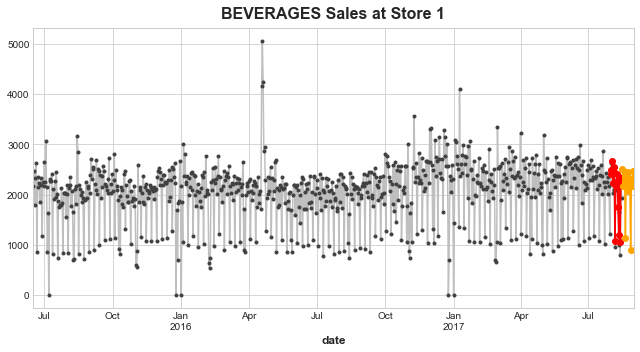

In [82]:
STORE_NBR = '1' 
FAMILY = 'BEVERAGES' 

ax = y.loc(axis=1)[STORE_NBR, FAMILY].plot(**plot_params, figsize=(9, 5))
ax = y_pred.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax, marker='.', color='red', markersize=12) 
ax = y_forecast.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax, marker='.', color='orange', markersize=12)

ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

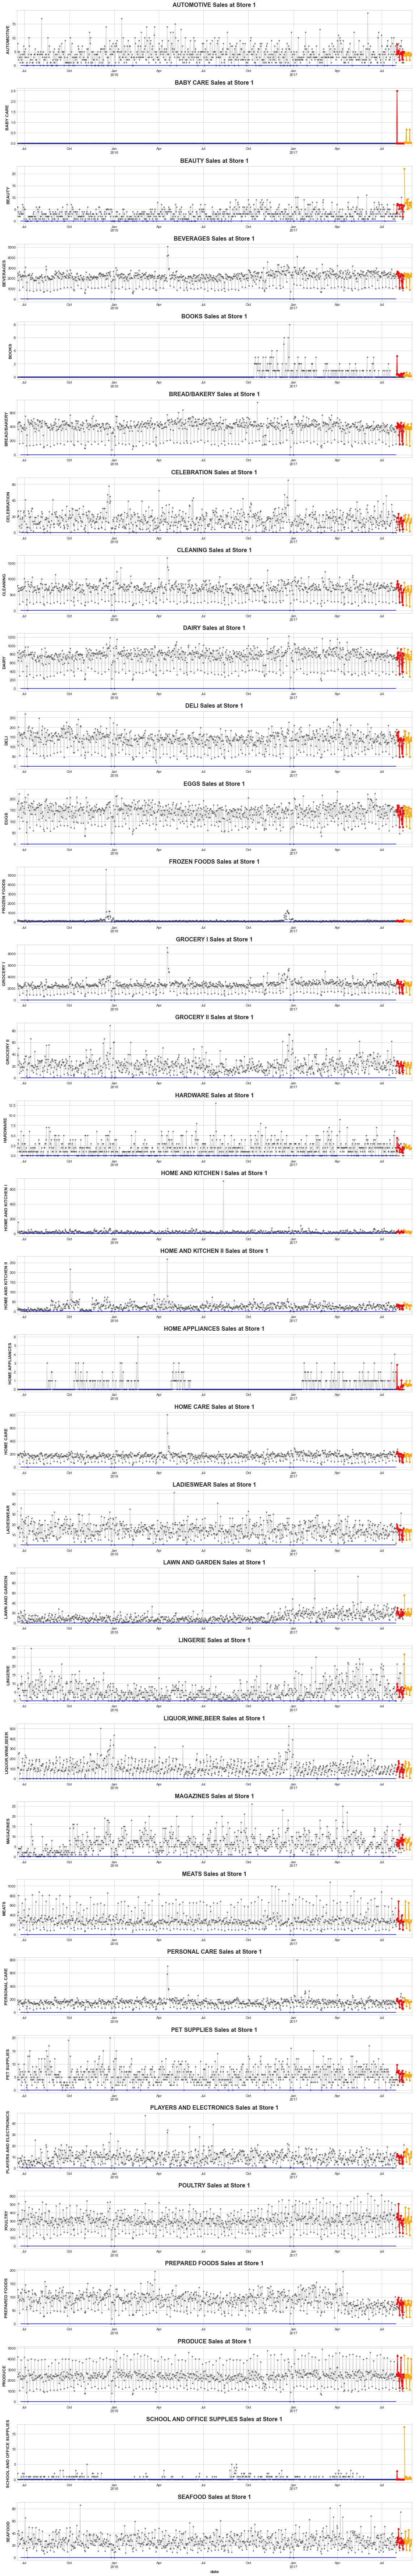

In [83]:
NUM_FAMILIES = 33   # 1 - 33
STORE_NBR = '1'    # 1 - 54

y_for_one_store = y.loc(axis=1)[STORE_NBR]
y_fit_for_one_store = y_fit.loc(axis=1)[STORE_NBR]
y_pred_for_one_store = y_pred.loc(axis=1)[STORE_NBR]
y_forecast_for_one_store = y_forecast.loc(axis=1)[STORE_NBR]
families = y_for_one_store.columns[0:NUM_FAMILIES]

axs = y_for_one_store.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(16, 3*NUM_FAMILIES), **plot_params, alpha=0.6,
)
_ = y_fit_for_one_store.loc(axis=1)[families].plot(subplots=True, sharex=True, color='blue', ax=axs)
_ = y_pred_for_one_store.loc(axis=1)[families].plot(subplots=True, sharex=True, color='red', ax=axs, marker='.', markersize=9) # markers: for tiny validation sets (1-2 days)
_ = y_forecast_for_one_store.loc(axis=1)[families].plot(subplots=True, sharex=True, color='orange', ax=axs, marker='.', markersize=9)

for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)
    ax.set_title(f'{family} Sales at Store {STORE_NBR}')
    ax.tick_params(labelbottom=True)

# SUMBISSION FILE

In [85]:
y_submit = y_forecast.stack(['store_nbr', 'family'])
y_submit = pd.DataFrame(y_submit, columns=['sales'])
y_submit = y_submit.join(test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [86]:
y_submit.head(10)

id        sales
date       store_nbr family                            
2017-08-16 1         AUTOMOTIVE    3000888     3.968019
                     BABY CARE     3000889     0.043969
                     BEAUTY        3000890    22.059293
                     BEVERAGES     3000891  2498.933437
                     BOOKS         3000892     0.148540
                     BREAD/BAKERY  3000893   453.568389
                     CELEBRATION   3000894    16.943523
                     CLEANING      3000895   884.370555
                     DAIRY         3000896   935.221982
                     DELI          3000897   181.886034